In [3]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import os

In [26]:
# Save dataset
os.system('wget -O train_data.csv "https://docs.google.com/spreadsheets/d/176-KrOP8nhLpoW91UnrOY9oq_-I0XYNKS1zmqIErFsA/gviz/tq?tqx=out:csv&sheet=train_data.csv" -q')
os.system('wget -O val_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')
os.system('wget -O test_data.csv "https://docs.google.com/spreadsheets/d/1YxjoAbatow3F5lbPEODToa8-YWvJoTY0aABS9zaXk-c/gviz/tq?tqx=out:csv&sheet=val_data.csv" -q')

0

In [5]:
import pandas as pd
df_train = pd.read_csv('train_data.csv')
df_valid = pd.read_csv('val_data.csv')
df_test = pd.read_csv('test_data.csv')

In [6]:
df_train.head()

,review,sentiment
0,I've watched this documentary twice - and alth...,positive
1,This is probably the worst movie I've seen in ...,negative
2,Superb story of a dedicated young teacher who ...,positive
3,<br /><br />Spoilers<br /><br />I'm going to b...,negative
4,"What can be said, really... ""The Tenant"" is a ...",positive


In [7]:
# Prepare data as X, Y
Xd, Yd = df_train.review.values.tolist(), df_train.sentiment.values.tolist()
Xv, Yv = df_valid.review.values.tolist(), df_valid.sentiment.values.tolist()
Xt, Yt = df_test.review.values.tolist(), df_test.sentiment.values.tolist()

sentiment = ['negative', 'positive']
Yd = [sentiment.index(y) for y in Yd]
Yv = [sentiment.index(y) for y in Yv]
Yt = [sentiment.index(y) for y in Yt]

In [21]:
# Extract features
def extract_features(X):
    
    feats = {'good_count': 0, 'bad_count': 0, 'bias': 1}
    words = X.split(' ')
    pos_words = ['good', 'great', 'excellent', 'positive', 'love', 'like', 
                 'awesome', 'amazing', 'wonderful', 'best', 'better', 
                 'beautiful', 'nice', 'fantastic', 'superb', 
                 'incredible', 'perfect', 'well', 'fun', 'enjoy', 
                 'enjoyable', 'enjoyed', 'enjoying', 'enjoyment']
    
    neg_words = ['hate', 'bad', 'horrible', 'awful', 'terrible', 'mess', 'frustating', 'frustatingly',
                 'worst', 'dumb', 'poor']
    
    for x in words:
        if x in pos_words:
            feats['good_count'] = feats.get('good_count', 0) + feats['bias']
        if x in neg_words:
            feats['bad_count'] = feats.get('good_count', 0) + feats['bias'] 
    return feats

def predict(X, w):
    feats = extract_features(X)
    score = 0
    for f in feats:
        score += feats[f] * w[f]
    return 1 if score > 0 else 0

def get_feature_weights():
    return {'good_count': 1.0, 'bad_count': -1.0, 'bias': 0.5}

def accuracy(Y_true, Y_pred):
    correct = 0.0
    total = len(Y_true)
    assert total == len(Y_pred)

    for i in range(total):
        if Y_true[i] == Y_pred[i]:
            correct += 1
    
    if total > 0:
        return 100.0 * correct / total
    return 0.0


In [22]:
feats_wt = get_feature_weights()
predictions = []

for x in Xt:
    y = predict(x, feats_wt)
    predictions.append(y)

print(accuracy(Yt, predictions))

60.475


In [24]:
feats_wt = get_feature_weights()
predictions = []

for x,y in zip(Xt,Yt):
    #print(x)
    y1 = predict(x, feats_wt)
    #print(y, y1)
    predictions.append(y1)

print(accuracy(Yt, predictions))

60.475


In [32]:
from sklearn.linear_model import LogisticRegression
def get_learnable_wt(Xd, Yd, feats_wt):
    feats_name = list(feats_wt(Xd[0]).keys())
    all_feats = []
    for x in Xd:
        feats = []
        feat_dict = extract_features(x)
        for f in feats_name:
            feats.append(feat_dict[feats_name])
        all_feats.append(feats)

    clf = LogisticRegression(fit_intercept=False, random_state = 42).fit(all_feats, Yd)
    coeffs = clf.coef_[0]
    coffs_dict = {feats_name[i]: coeffs[i] for i in range(len(feats_name))}
    print(feats_name)
    return coffs_dict

In [33]:
feats_wt_logistic = get_learnable_wt(Xd, Yd, extract_features)
predictions = []

for x in Xt:
    y = predict(x, feats_wt_logistic)
    predictions.append(y)

print("Accuracy on Logistic Regression : ",accuracy(Yt, predictions))

['good_count', 'bad_count', 'bias']
Accuracy on Logistic Regression :  66.7


(-2.0, 2.0)

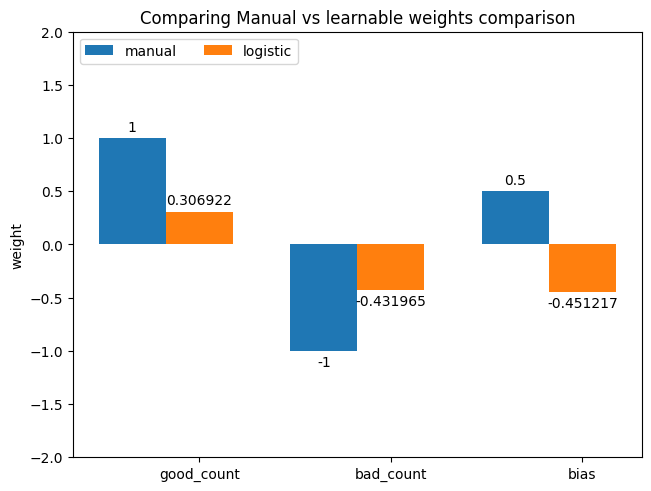

In [37]:
import matplotlib.pyplot as plt
import numpy as np

feats_names = list(feats_wt_logistic.keys())
manual_wt = [feats_wt[f] for f in feats_names]
logistic_wt = [feats_wt_logistic[f] for f in feats_names]

wt_dict = {'manual': manual_wt, 'logistic': logistic_wt}
x = np.arange(len(feats_names))  # the label locations
width = 0.35  # the width of the bars
multiplier = 0

fig, ax = plt.subplots(layout='constrained');

for attribute, measurement in wt_dict.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('weight')
ax.set_title('Comparing Manual vs learnable weights comparison')
ax.set_xticks(x + width, feats_names)
ax.legend(loc='upper left', ncols=2)
ax.set_ylim(-2, 2)